## The Functions of the Discrete Voter Model

This notebook runs the following $5$ subroutines for the **discrete voter model**:
1. `make_grid`: create a probabilistic grid: an $\mathbf{R}^n$ array of values, $\omega$, that all sum to $1$
2. `shift_weight`: shift weight in a grid reversibly
3. `expec_votes`: given a grid, a candidate, and a district description, output the expectation of votes that candidate received
4. `prob_votes`: given a grid, a candidate, a district description, and the observed vote outcomes, output the probability of seeing that outcome
5. `mcmc`: run a Markov Chain Monte Carlo method on a state space of grids

`generate_random_election` generates a random election when given candidate and demographic information.

In [189]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import seaborn as sns
import pymc3 as pm
import time
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import functools

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from itertools import chain, permutations
from tqdm import trange, tqdm

%matplotlib inline

In [138]:
# Import written packages

import make_grid as mg
import prob_votes as pv
import expec_votes as ev
import shift_weight as sw

import kings_ei as kei
import dvm
import dvm_plot

import tools
import election

In [3]:
%load_ext line_profiler

### `make_grid`
Create a probabilistic grid: an $\mathbf{R}^n$ array of values, $\omega$, that all sum to $1$.

In [4]:
test_grid = mg.make_grid(3, 10)

In [5]:
test_grid

<tf.Tensor: shape=(10, 10, 10), dtype=float32, numpy=
array([[[2.57861335e-04, 2.21804570e-04, 1.34109892e-03, 1.41447759e-03,
         2.28838107e-05, 1.92220975e-03, 8.50880460e-04, 1.55121228e-03,
         1.79598480e-03, 1.50780950e-03],
        [3.85580002e-04, 1.76780112e-03, 1.75511360e-03, 1.57319068e-03,
         1.54223977e-04, 3.77884367e-04, 1.00236654e-03, 1.32117863e-03,
         4.02224163e-04, 5.34122810e-04],
        [2.99399922e-04, 6.90988090e-04, 1.74202898e-03, 1.80709444e-03,
         1.89888023e-03, 5.45852527e-04, 1.87373045e-03, 4.04702179e-04,
         1.94739446e-03, 4.37241804e-04],
        [1.03606307e-03, 1.63005979e-03, 4.92191873e-04, 8.57386767e-05,
         1.50034030e-03, 1.58900919e-03, 8.12322367e-04, 1.33583008e-03,
         1.82880124e-03, 3.78010824e-04],
        [1.95947406e-03, 6.69989386e-04, 1.08714355e-03, 6.29530812e-04,
         1.57683599e-03, 6.78452998e-05, 1.54686568e-03, 1.35891302e-03,
         5.14980711e-05, 1.23240822e-03],
      

### `expec_votes`
Given a grid, a candidate, and a district description, output the expectation of votes that candidate received.

In [6]:
test_demo = {"Black": 10, "white": 8, "Latinx": 5}

In [7]:
ev.expec_votes(test_grid, test_demo)

<tf.Tensor: shape=(), dtype=float32, numpy=10.378355>

### `prob_votes`
Given a grid, a candidate, a district description, and the observed vote outcomes, output the probability of seeing that outcome.

In [8]:
test_observed = 10

In [9]:
test_coeff_dict = election.get_coefficients(test_demo, test_observed)

In [10]:
pv.prob_votes(test_grid, test_demo, test_observed, test_coeff_dict)

<tf.Tensor: shape=(), dtype=float32, numpy=-3.185233>

In [11]:
test_num_trials = 25
bounds_error_count = 0
for _ in trange(test_num_trials):
    log_prob = pv.prob_votes(mg.make_grid(3, 10), 
                      test_demo, test_observed, test_coeff_dict)
    x = tf.math.exp(log_prob)
    if x > 1 or x < 0:
        bounds_error_count += 1
        print(f"Probability out of bounds at {x}")
if bounds_error_count == 0:
    print(f"No bounds errors in {test_num_trials} trials")
else:
    print(f"There were {bounds_error_count} bounds errors")

100%|██████████| 25/25 [00:13<00:00,  1.82it/s]

No bounds errors in 25 trials


### `mcmc`
Run a Markov Chain Monte Carlo method on a state space of grids.

In [38]:
rwm_test_chain_results = dvm.rwm(
    20, 0.4, 
    test_grid,
    test_demo, test_observed, expec_scoring=True)

The Random Walk Metropolis chain will be run in 2 chunks of size 10, with 0 steps at the end.

[1/3] Running the chain on 2 chunks of 10 iterations each...



[2/3] Running the chain for 0 more steps...
[3/3] Burning 0.4 of the sample...
Done.
Generated a sample of 12 observations in ~1 seconds.


In [29]:
hmc_test_chain_results = dvm.hmc(
    3, 0.4, 
    test_grid,
    test_demo, test_observed, expec_scoring=True)

This Hamiltonian Monte Carlo chain will be run in 0 chunks of size 10, with 0 steps of adaptation and 3 steps at the end.

[1/3] Running the chain for 0 steps to adapt the step size...
[2/3] Running the chain with a step size of 0.03 on 0 chunks of 10 iterations each...



[3/3] Running the chain for 3 more steps...
(3, 10, 10, 10)
[4/3] Burning 0.4 of samples...
Done.
Generated a sample of 2 observations in ~1 seconds.


In [32]:
dvm.mle(rwm_test_chain_results)

(<tf.Tensor: shape=(10, 10, 10), dtype=float32, numpy=
 array([[[1.0838137e-04, 4.5332496e-04, 1.2154228e-03, 8.4690598e-04,
          6.3677289e-04, 7.3929300e-04, 1.1046387e-03, 1.1052184e-03,
          1.0240707e-03, 8.0428965e-04],
         [1.4680204e-03, 1.2569348e-03, 1.1122184e-03, 1.4245638e-03,
          9.1188255e-04, 1.1238251e-03, 1.2314779e-03, 1.1121905e-03,
          9.3096995e-04, 9.4106147e-04],
         [1.2063178e-03, 5.3716835e-04, 9.7281148e-04, 7.8455789e-04,
          1.5379420e-03, 1.3541498e-03, 9.4923005e-04, 6.5640453e-04,
          8.9569588e-04, 5.3038949e-04],
         [1.6191986e-03, 1.3615794e-03, 1.1513233e-03, 1.0218192e-03,
          9.4181835e-04, 5.1608263e-04, 1.3380268e-03, 6.5817690e-04,
          4.7581954e-04, 1.2444986e-03],
         [2.1272904e-04, 1.1150275e-03, 7.7588425e-04, 1.2552392e-03,
          8.5884723e-04, 6.7353138e-04, 8.2169042e-04, 1.4483536e-03,
          1.3792473e-03, 1.3832819e-03],
         [1.0968397e-03, 1.2218104e-03, 

In [28]:
rwm_test_chain_results['scorer']

'expec'

In [30]:
dvm.mean_phc(rwm_test_chain_results)

<tf.Tensor: shape=(10, 10, 10), dtype=float32, numpy=
array([[[0.00041705, 0.00042241, 0.00115881, 0.00087762, 0.00073934,
         0.0006413 , 0.00098535, 0.00125331, 0.00085551, 0.00085268],
        [0.00128193, 0.00108453, 0.00106463, 0.00125433, 0.00104468,
         0.00109625, 0.00134748, 0.00115905, 0.00082036, 0.00079591],
        [0.00117795, 0.00069798, 0.00113917, 0.00086491, 0.00142008,
         0.00122054, 0.00127909, 0.00080559, 0.00098111, 0.00082482],
        [0.00153551, 0.00147039, 0.00111947, 0.00100423, 0.00092905,
         0.00073429, 0.00151247, 0.00080084, 0.00052726, 0.00124288],
        [0.00015822, 0.00093223, 0.00059441, 0.00139061, 0.00076201,
         0.00076387, 0.00073232, 0.00152102, 0.00135893, 0.0012456 ],
        [0.00100964, 0.00102876, 0.00105507, 0.00109473, 0.00108575,
         0.0008845 , 0.00112152, 0.00047706, 0.00133407, 0.00054938],
        [0.00114054, 0.0012763 , 0.00110803, 0.00042638, 0.00065794,
         0.00112845, 0.00105278, 0.00099814

### Visualizations

In [41]:
rwm_test_chain_results.keys()

dict_keys(['sample', 'scorer', 'log_prob_trace', 'log_accept_trace'])

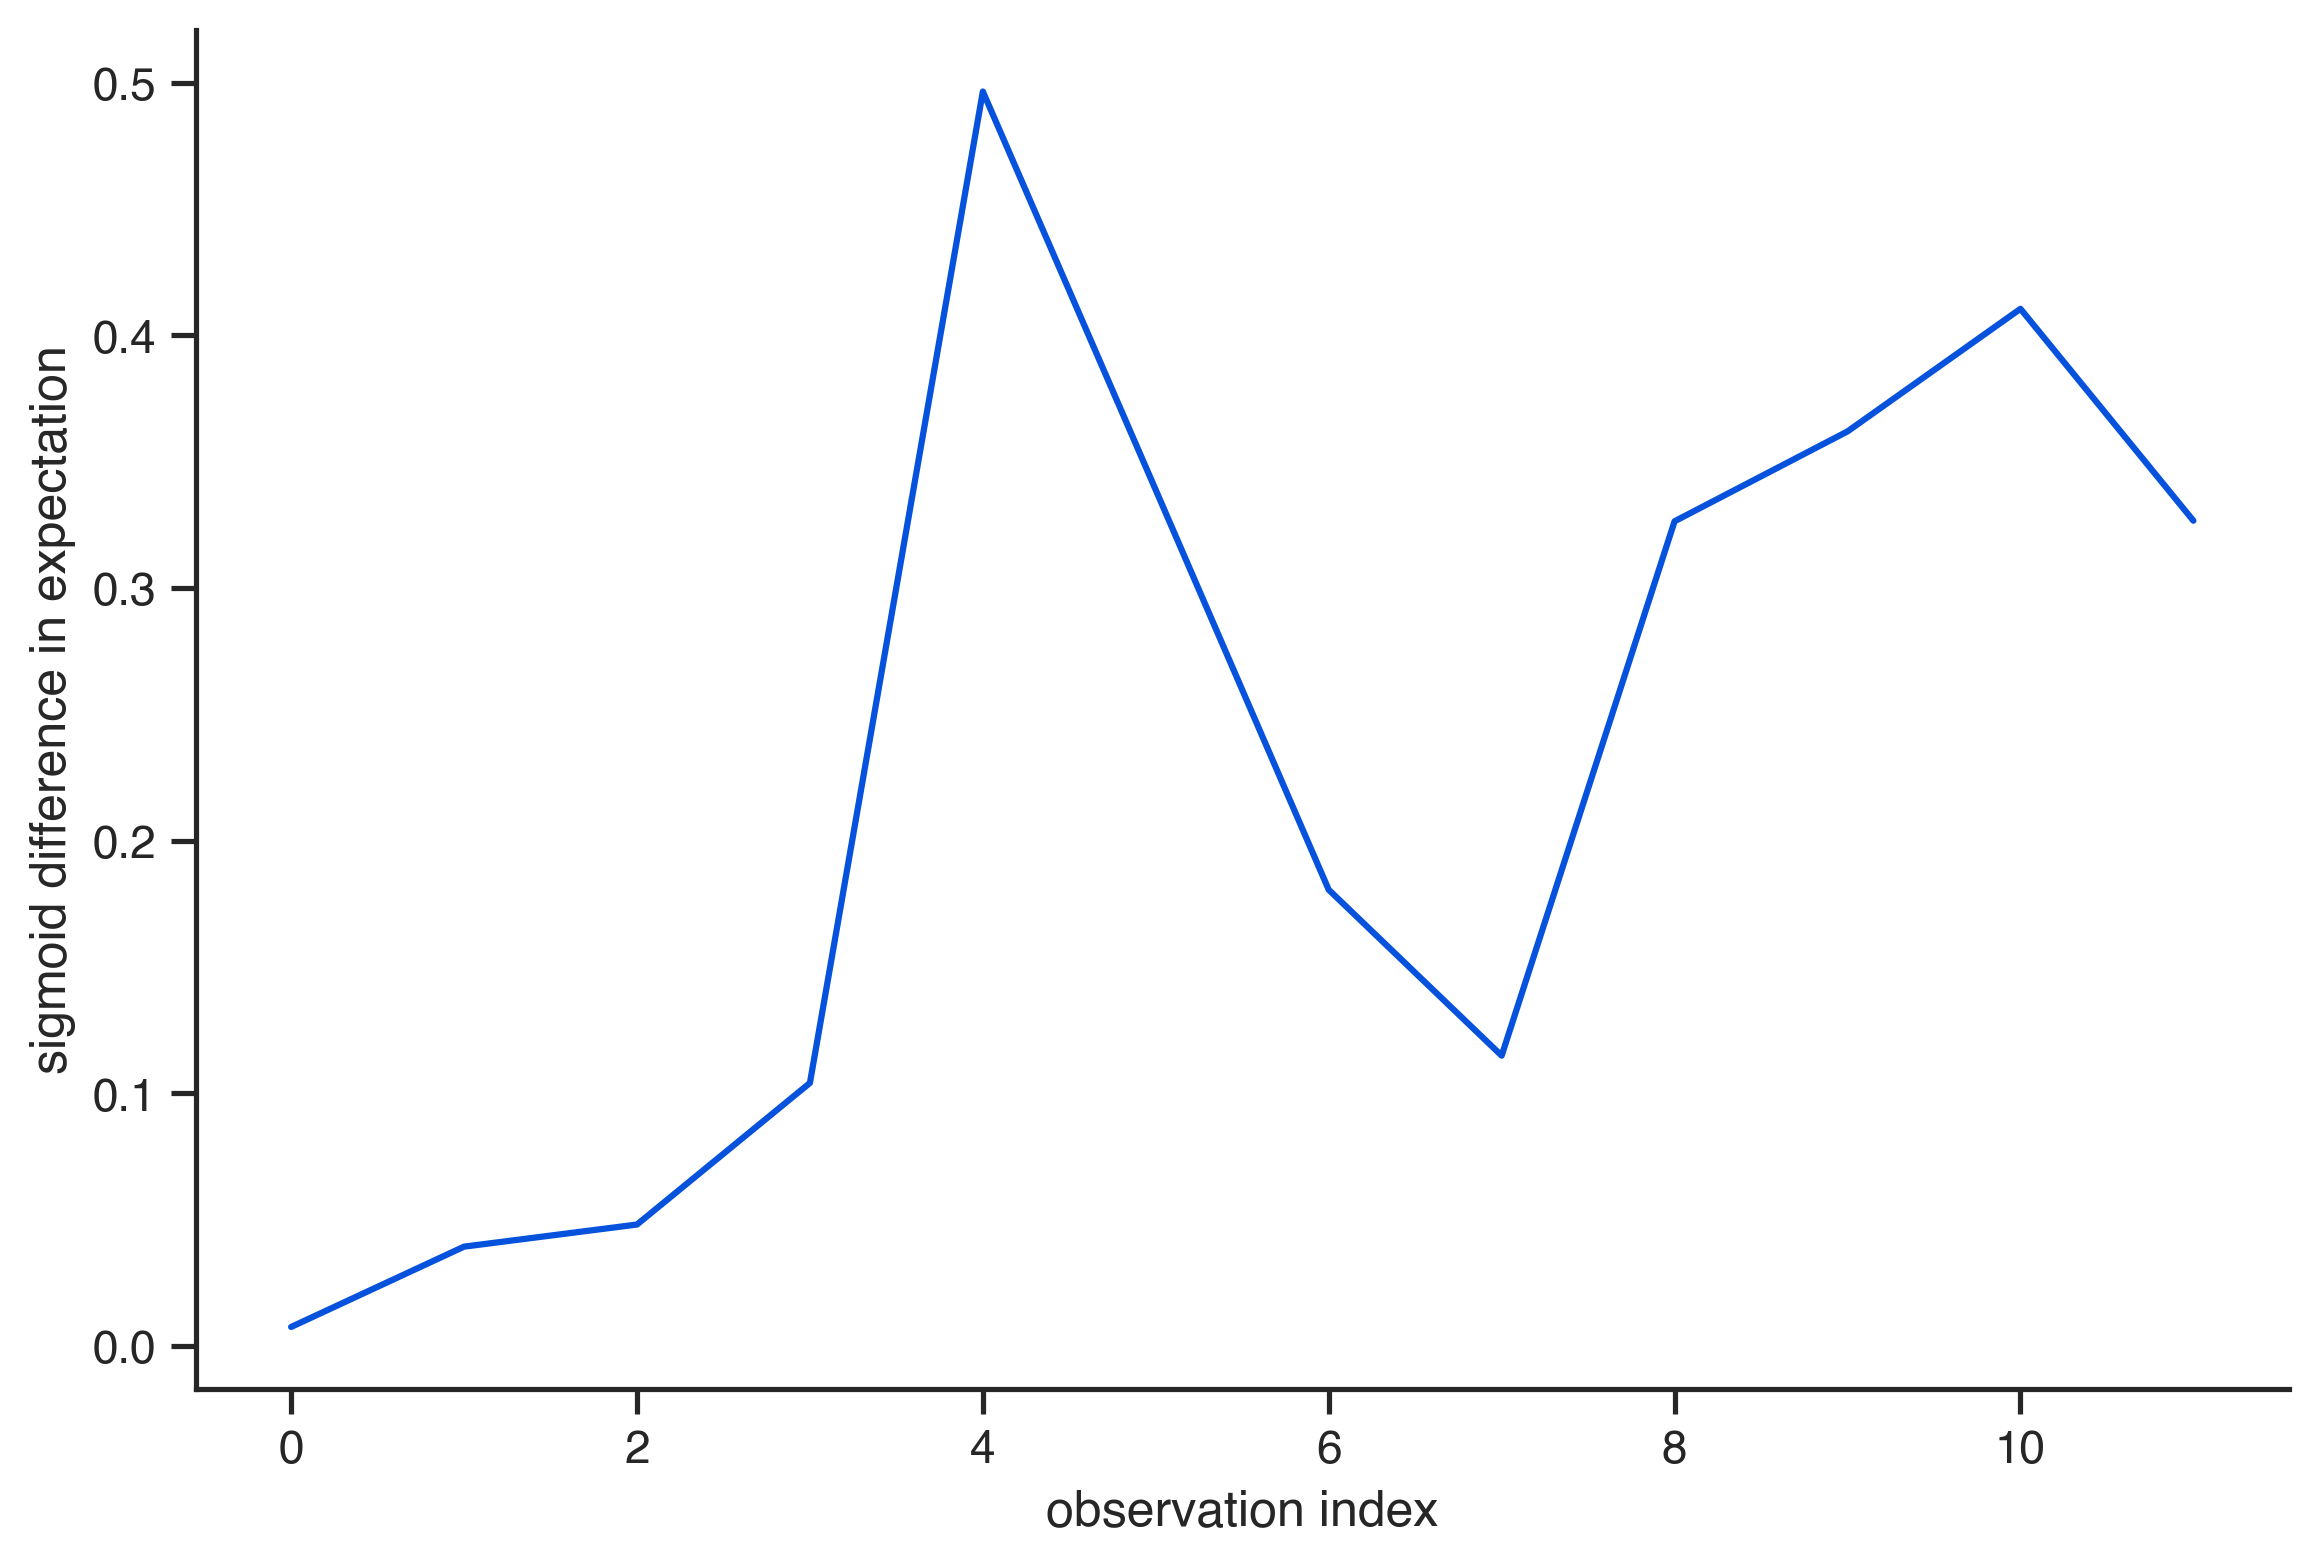

In [140]:
dvm_plot.trace_plot(rwm_test_chain_results, save=True)

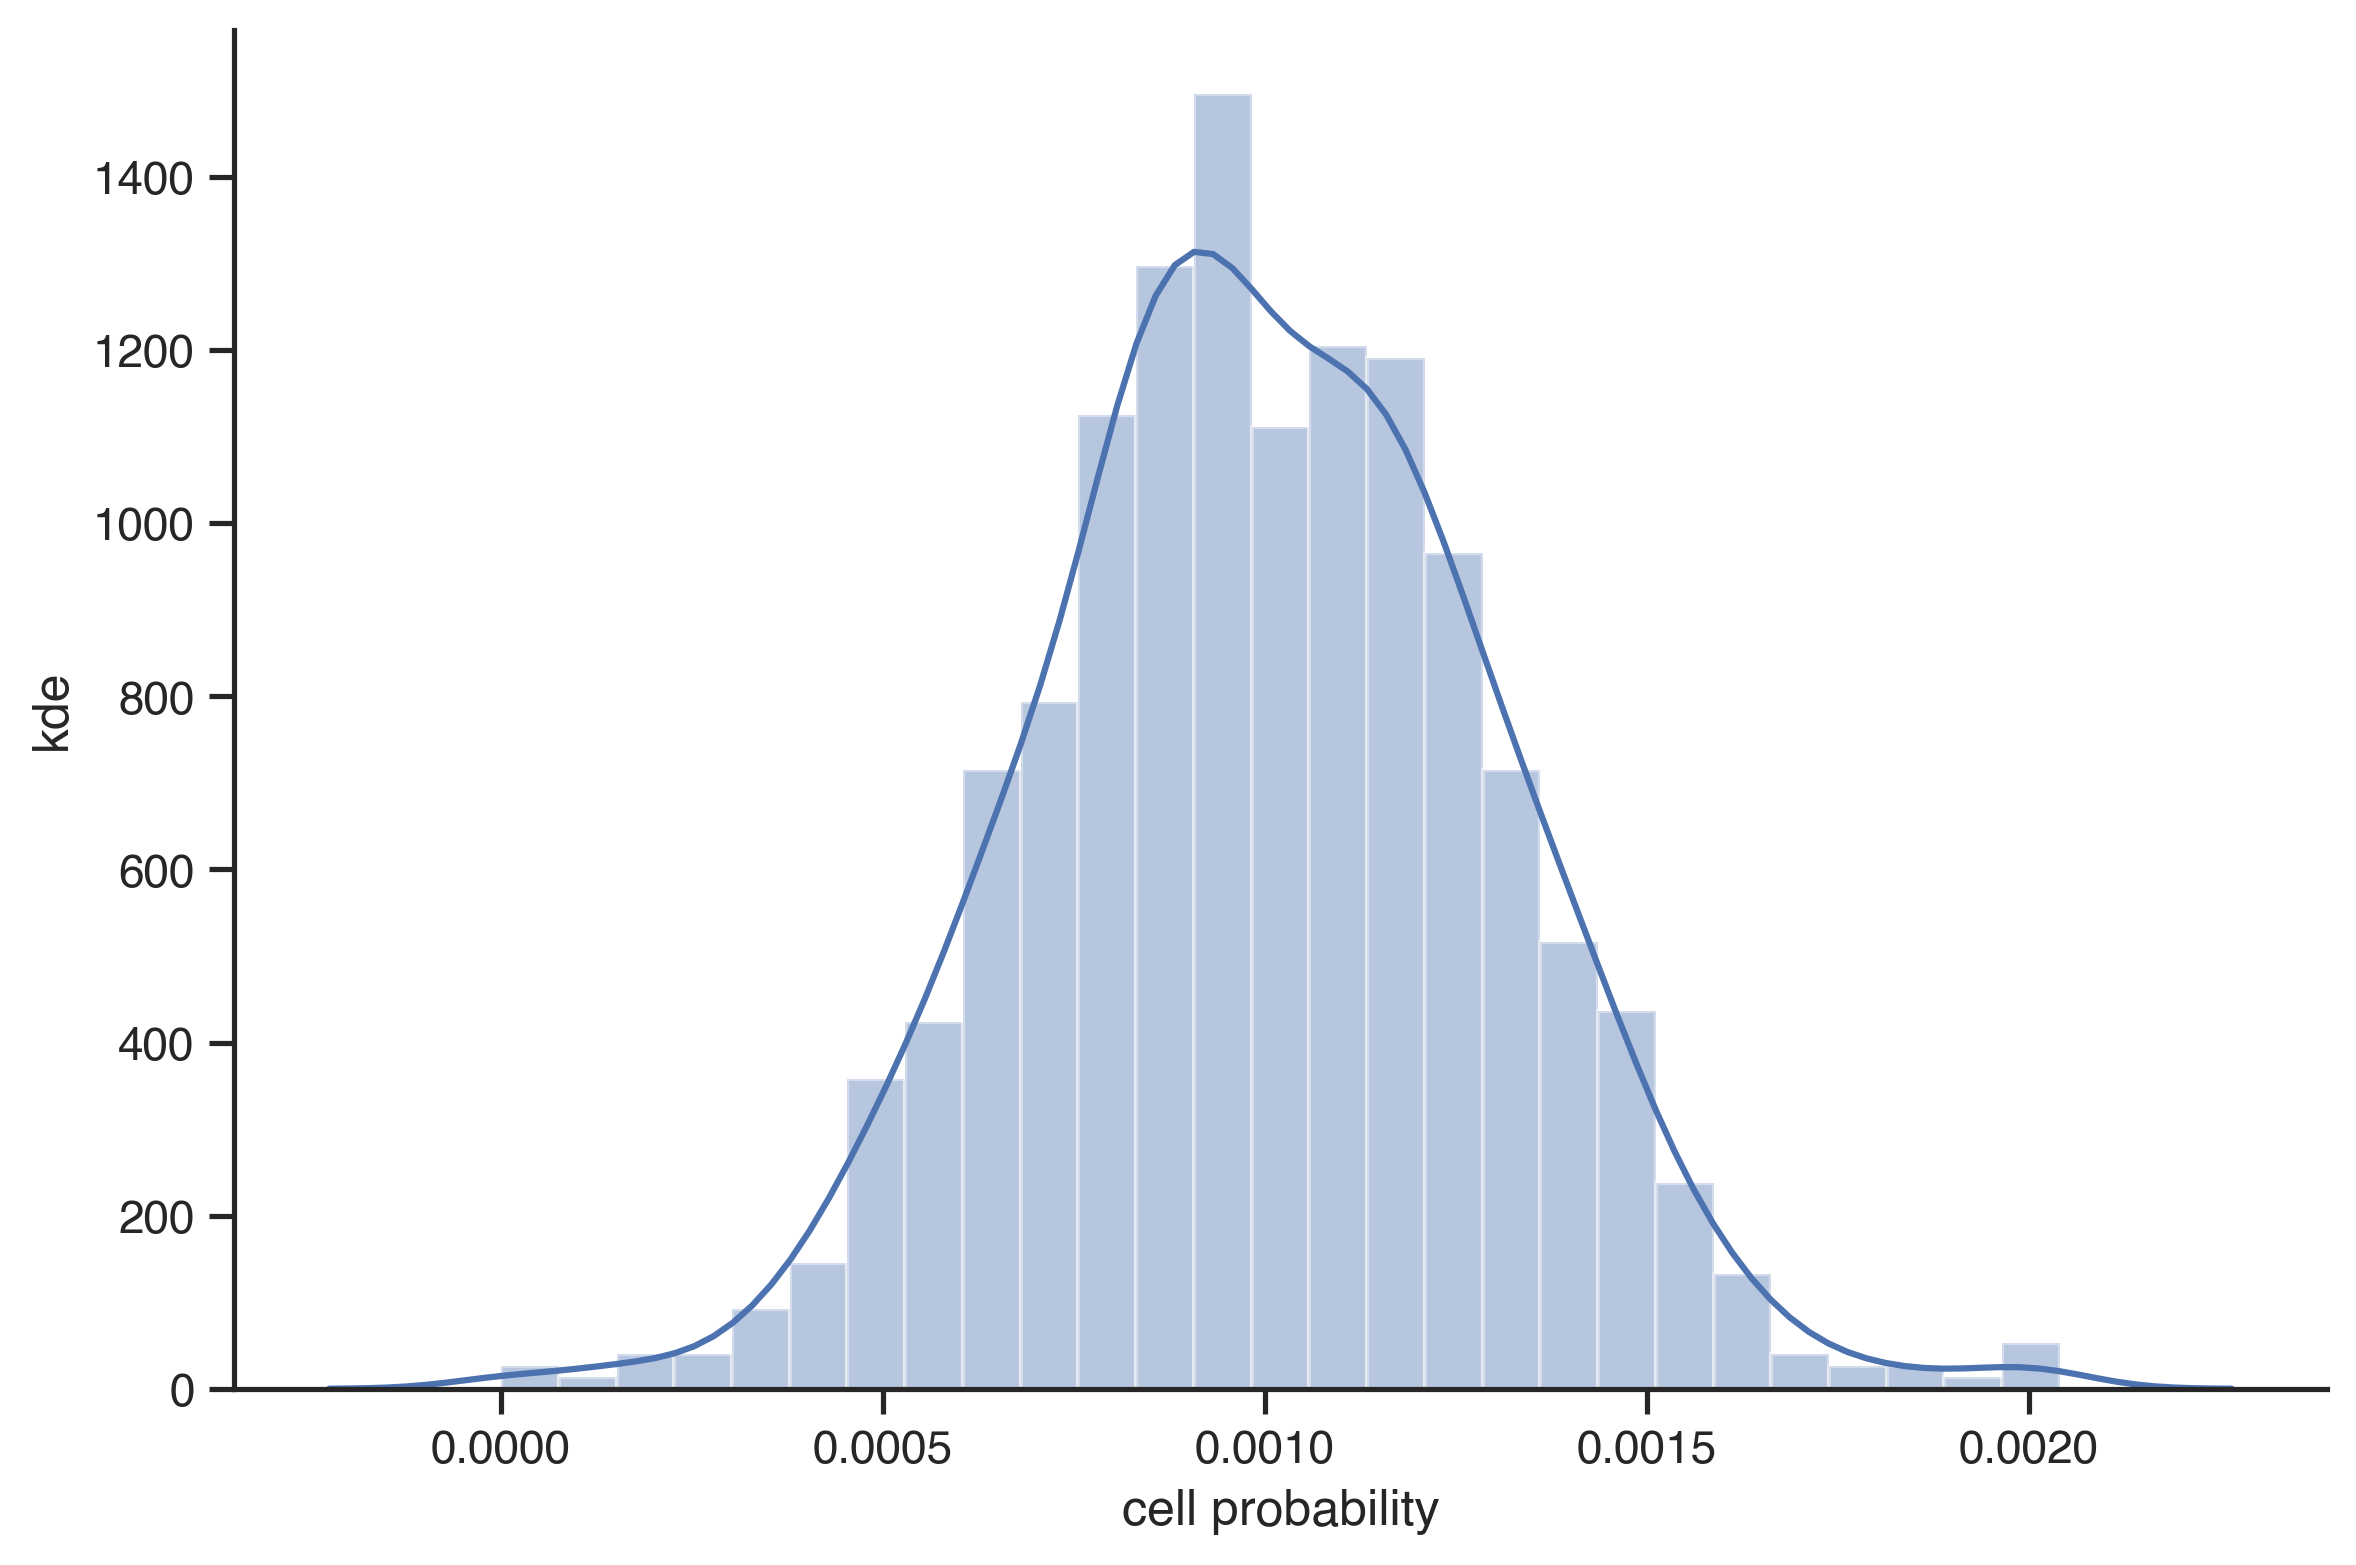

In [144]:
dvm_plot.phc_plot_2d(best_grid)

In [ ]:
best_test_cell = np.unravel_index(np.argmax(flat_best_grid), best_grid.shape)
best_test_cell

In [345]:
test_grid_2d = mg.make_grid(2, 10)

In [350]:
test_grid_2d.shape

TensorShape([10, 10])

In [376]:
test_demo_2d = {'Black': 10, 'white': 8}

In [436]:
test_grid[(3,4,5)]

<tf.Tensor: shape=(), dtype=float32, numpy=0.0008437878>

In [439]:
"{:.1e}".format(test_grid[(3,4,5)])

'8.4e-04'

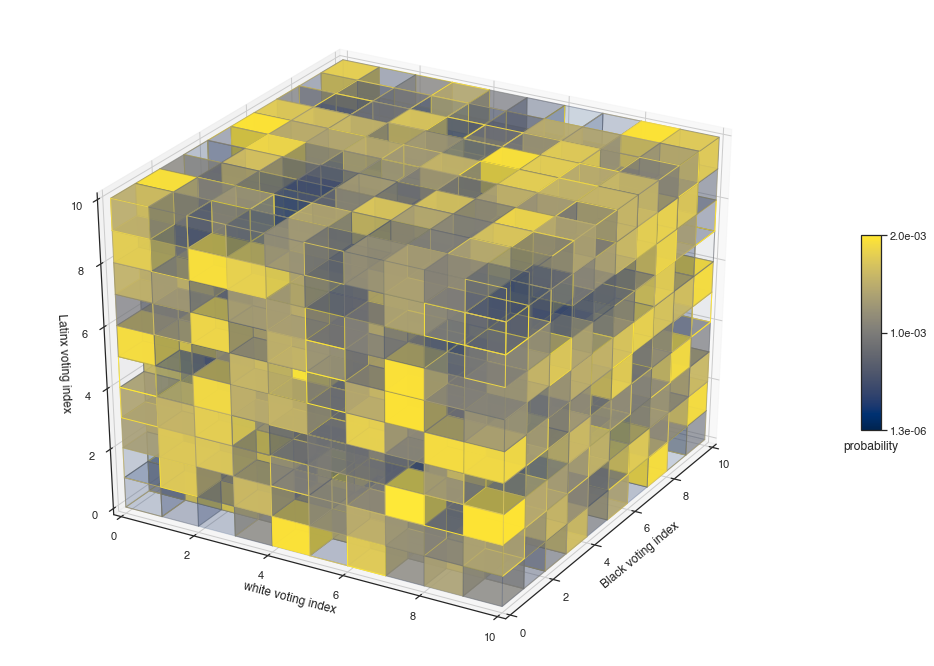

In [445]:
dvm_plot.phc_plot_3d(test_grid, demo=test_demo, save=True)

In [466]:
import importlib

importlib.reload(pv)
importlib.reload(sw)
importlib.reload(mg)
importlib.reload(ev)
importlib.reload(tools)
importlib.reload(election)
importlib.reload(dvm)
importlib.reload(plt)
importlib.reload(dvm_plot)

<module 'dvm_plot' from '/Users/hakeemangulu/Google Drive/Academic/Senior Spring/Thesis/thesis/code/dvm_plot.py'>

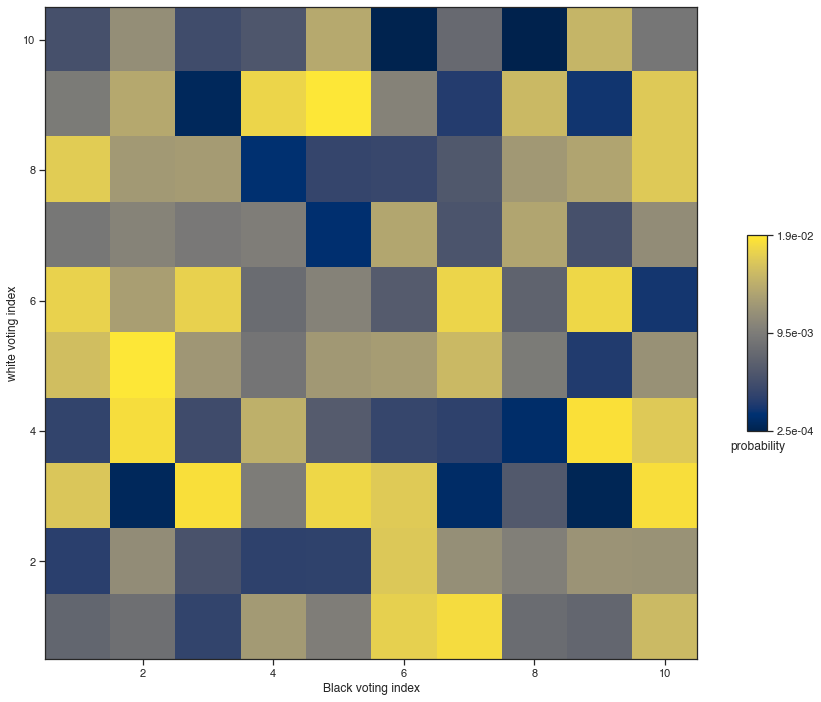

In [467]:
dvm_plot.phc_plot_2d(test_grid_2d, test_demo_2d)

In [ ]:
test_demo_2d = {'Black': 10, 'white': 8}

In [ ]:
test_observed_2d = 7

In [ ]:
test_results_2d = metropolis_hastings(100, test_grid_2d, test_observed_2d, test_demo_2d, scoring_type='prob', shift_type='uniform')

In [ ]:
best_test_grid_2d = test_results_2d['best_grid']
best_test_grid_2d

In [ ]:
def get_most_probable_cell(grid):
    """
    Find the most probable cell in a grid.
    
    grid (NumPy array): the probabilistic grid
    
    return: the index of the most probable cell
    """
    return np.unravel_index(np.argmax(grid.flatten()), grid.shape)

In [ ]:
best_test_cell_2d = get_most_probable_cell(best_test_grid_2d)
best_test_cell_2d

In [468]:
def visualize_2d_grid(grid, demo):
    grid_indices = np.arange(grid.shape[0])
    test_x, test_y = np.meshgrid(grid_indices, grid_indices)
    
    fig = plt.figure(figsize=(9,6))
    ax = fig.gca(projection='3d')
    surface = ax.plot_surface(test_x, test_y, test_prob_in_cell((test_x, test_y), grid), rstride=1, cstride=1, edgecolor='none', cmap='Blues')
    colorbar = fig.colorbar(surface, shrink=0.5, aspect=10)
    colorbar.ax.set_ylabel('probability')
    
    demo_groups = list(demo.keys())
    ax.set_xlabel(f"Group 1 voting index")
    ax.set_ylabel(f"Group 2 voting index")
    plt.savefig("images/2d_viz.png")
    plt.show()

NameError: name 'test_prob_in_cell' is not defined

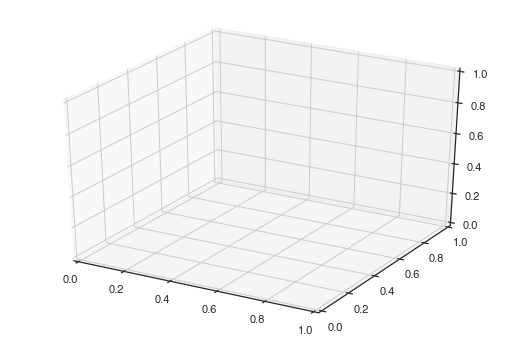

In [469]:
visualize_2d_grid(test_grid_2d, test_demo_2d)

### `generate_random_election`

Generate a random election.

In [ ]:
def generate_random_election(candidates, demo, beta):
    """
    Generate a random election.
    
    candidates (string list): the candidates
    demo (dict): the demographics of the electorate
    beta (dict): the theoretical voting percentages of
    each demographic group, for each candidate
    
    return: a dictionary of candidates and the vote breakdowns by
    demographic group
    """
    # Set up the result dictionary
    num_groups = len(demo)
    result = {'a': (0, [0] * num_groups), 
              'b': (0, [0] * num_groups), 
              'c': (0, [0] * num_groups)}
    
    # Iterate through each demographic group
    for group_index, group in enumerate(demo):
        # Simulate each voter
        for voter in range(demo[group]):
            vote = np.random.choice(candidates, 1, beta[group])[0]
            prev_total, prev_breakdown = result[vote]
            prev_breakdown[group_index] += 1
            result[vote] = prev_total + 1, prev_breakdown
    return result

In [ ]:
test_candidates = ['a', 'b', 'c']
test_beta = {'Black': [0.4, 0.5, 0.1], 
             'white': [0.3, 0.2, 0.5], 
             'Latinx': [0.3, 0.5, 0.2]}

In [ ]:
test_random_election = generate_random_election(test_candidates, test_demo, test_beta)

In [ ]:
test_random_election

In [ ]:
test_observed_from_elec = 0
for candidate in test_random_election:
    test_observed_from_elec += test_random_election[candidate][0]
test_observed_from_elec

In [ ]:
test_demo

In [ ]:
test_results_with_elec = metropolis_hastings(500, test_grid, 11, test_demo, scoring_type='prob')

In [ ]:
test_results_with_elec.keys()

In [ ]:
test_results_with_elec['best_grid']

In [ ]:
visualize_3d_grid(test_results_with_elec['best_grid'], test_demo)

In [ ]:
temp1 = get_most_probable_cell(test_results_with_elec['best_grid'])

In [ ]:
temp2 = test_prob_in_cell(temp1, test_results_with_elec['best_grid'])

In [ ]:
get_vote_pcts(temp1, 10, test_demo)

### King's Ecological Inference

Reference: https://gist.github.com/ColCarroll/9fb0e6714dc0369acf6549cededcc875

In [ ]:
def ei_two_by_two(demo_pcts, candidate_pcts, precint_populations, lmbda=0.5):
    """
    Run King's Ecological Inference method on
    a 2x2 example (2 demographic groups).
    
    group_demo_pcts (NumPy array): the percentage of people in the
    demographic group for each precinct
    group_voting_pcts (NumPy array): the percentage of people in the
    precinct who voted for a candidate
    precint_populations (NumPy array): the populations of the
    precincts
    lmbda (float): 
    
    return: the probabilistic model
    """
    demo_counts = candidate_pcts * precint_populations
    # Number of populations
    p = len(precint_populations) 
    with pm.Model() as model:   
        c_1 = pm.Exponential('c_1', lmbda)
        d_1 = pm.Exponential('d_1', lmbda)
        c_2 = pm.Exponential('c_2', lmbda)
        d_2 = pm.Exponential('d_2', lmbda)
        
        b_1 = pm.Beta('b_1', alpha=c_1, beta=d_1, shape=p)
        b_2 = pm.Beta('b_2', alpha=c_2, beta=d_2, shape=p)
    
        theta = demo_pcts * b_1 + (1 - demo_pcts) * b_2
        Tprime = pm.Binomial('Tprime', n=precint_populations , p=theta, observed=demo_counts)       
    return model

In [ ]:
# Model four districts
group_demo_pcts = np.array([.1, .2, .3, .4])
group_voting_pcts = np.array([.11, .18, .34, .4])
precint_populations = np.array([100, 100, 100, 100])

In [ ]:
toy_model = ei_two_by_two(group_demo_pcts, group_voting_pcts, precint_populations)

with toy_model:
    toy_trace = pm.sample()

In [ ]:
# Plot the traces
pm.traceplot(toy_trace);

In [ ]:
print(f"b_1 mean across districts: {str(toy_trace.get_values('b_1').mean())}")

pm.stats.summary(toy_trace, var_names=['b_1', 'b_2'])

In [ ]:
# Run on a 40% Black, 60% white precinct
ei_test_demo = np.array([.4])
ei_test_candidate_vote = np.array([.5])
ei_precinct_population = np.array([10])

In [ ]:
test_trace

In [ ]:
test_model = ei_two_by_two(ei_test_demo, ei_test_candidate_vote, ei_precinct_population)

with test_model:
    test_trace = pm.sample()

In [ ]:
# Plot the traces
pm.traceplot(test_trace);

In [ ]:
print(f"b_1 mean across districts: {str(toy_trace.get_values('b_1').mean())}")

pm.stats.summary(toy_trace, var_names=['b_1', 'b_2'])

### Comparison of EI to Discrete Voter Model

In [ ]:
grid_vs_ei_demo = {"Black": 4, "white": 6}
grid_vs_ei_observed = 5

In [ ]:
test_grid_vs_ei = metropolis_hastings(100, make_grid(2, 10), grid_vs_ei_observed, grid_vs_ei_demo, scoring_type='prob')

In [ ]:
test_best_grid_vs_ei = test_grid_vs_ei["best_grid"]

In [ ]:
visualize_2d_grid(test_grid_vs_ei["best_grid"], grid_vs_ei_demo)

### Evaluation

In [ ]:
def mse(a, b):
    """
    Find the mean squared error between
    two one-dimensional NumPy arrays.
    
    a (NumPy array-like): the first array
    b (NumPy array-like): the second array
    
    return: a float of the MSE
    """
    return np.mean((a - b) ** 2)

In [ ]:
eval_candidates_2 = ['a', 'b']

In [ ]:
# 2D evaluation
eval_demo_1 = {'Group 1': 50, 'Group 2': 50}
eval_demo_2 = {'Group 1': 25, 'Group 2': 75}
eval_demo_3 = {'Group 1': 10, 'Group 2': 90}

In [ ]:
eval_beta_1 = {'Group 1': [0.5, 0.5], 
               'Group 2': [0.3, 0.7]}
eval_beta_2 = {'Group 1': [0.25, 0.75], 
               'Group 2': [0.2, 0.8]}

In [ ]:
experiments_2d = []
random_election_1_1 = generate_random_election(eval_candidates, eval_demo_1, eval_beta_1)
experiments_2d.append((random_election_1_1, eval_demo_1, eval_beta_1, "1_1"))

random_election_1_2 = generate_random_election(eval_candidates, eval_demo_1, eval_beta_2)
experiments_2d.append((random_election_1_2, eval_demo_1, eval_beta_2, "1_2"))

random_election_2_1 = generate_random_election(eval_candidates, eval_demo_2, eval_beta_1)
experiments_2d.append((random_election_2_1, eval_demo_1, eval_beta_2, "2_1"))

random_election_2_2 = generate_random_election(eval_candidates, eval_demo_2, eval_beta_2)
experiments_2d.append((random_election_2_2, eval_demo_2, eval_beta_2, "2_2"))

random_election_3_1 = generate_random_election(eval_candidates, eval_demo_3, eval_beta_1)
experiments_2d.append((random_election_1_1, eval_demo_3, eval_beta_1, "3_1"))

random_election_3_2 = generate_random_election(eval_candidates, eval_demo_3, eval_beta_2)
experiments_2d.append((random_election_3_2, eval_demo_3, eval_beta_2, "3_2"))

In [ ]:
experiments_2d

In [ ]:
def dvm_king_evaluator(election, demo, beta, label, n_iter=1):
    """
    Run and compare the results of the Discrete
    Voter Model and King's EI on generated
    election data.
    
    election (dict): the random election to
    evaluate on
    demo (dict): the demographic dictionary of
    a precinct
    n_iter (int): the number of times to repeat
    the experiment
    label (string): the label of the experiment
    
    return: a dictionary of the label and times and MSEs for
    the Discrete Voter Model and King's EI
    """
    results = {}
    dvm_total_time = 0
    dvm_total_mse = 0

    king_total_time = 0
    king_total_mse = 0

    temp_pcts_array = [pcts[0] for group, pcts in beta.items()]
    true_pcts = np.fromiter(temp_pcts_array, dtype=float)

    for _ in range(n_iter):
        # Get the observed votes for candidate a
        candidate_a_obs = random_election_1_1['a'][0]

        # Run Metropolis-Hastings and time it
        met_iter = 100 if len(demo) > 2 else 200
        dvm_total_time -= time.time()
        initial_grid = make_grid(len(demo), 10)
        met_result = metropolis_hastings(met_iter, initial_grid, candidate_a_obs, demo, scoring_type='prob')
        dvm_total_time += time.time()

        # Find the best grid and output the result
        best_grid = met_result['best_grid']
        best_cell = get_most_probable_cell(met_result['best_grid'])
        vote_pcts = get_vote_pcts(best_cell, 10, demo)

        # Find the MSE of the result
        dvm_mse_array = np.fromiter(vote_pcts.values(), dtype=float)
        dvm_total_mse += mse(dvm_mse_array, true_pcts)

        # Run King's EI and time it, if at the right dimension
        if len(demo) > 2:
            continue
        king_demo = list(demo.values())[0] / 100
        king_cand_vote = candidate_a_obs / 100
        king_prec_pop = np.array([100])

        king_total_time -= time.time()
        king_model = ei_two_by_two(king_demo, king_cand_vote, king_prec_pop)
        with king_model:
            king_trace = pm.sample()
        king_total_time += time.time()

        # Find the MSE of the result
        king_mse_array = np.fromiter([king_trace.get_values('b_1').mean(), 
                                      king_trace.get_values('b_2').mean()], 
                                     dtype=float)

        king_total_mse += mse(king_mse_array, true_pcts)


    return {'label': label,
            'dvm_time': dvm_total_time / n_iter, 
            'dvm_mse': dvm_total_mse / n_iter, 
            'king_time': king_total_time / n_iter, 
            'king_mse': king_total_mse / n_iter}

In [ ]:
dvm_king_evaluator(random_election_1_1, eval_demo_1, eval_beta_1, "1_1")

In [ ]:
# 3D evaluation
eval_demo_4 = {'Group 1': 50, 'Group 2': 50, 'Group 3': 0}
eval_demo_5 = {'Group 1': 25, 'Group 2': 25, 'Group 3': 50}
eval_demo_6 = {'Group 1': 33, 'Group 2': 33, 'Group 3': 34}

In [ ]:
eval_beta_3 = {'Group 1': [0.2, 0.8], 
               'Group 2': [0.8, 0.2], 
               'Group 3': [0.4, 0.6]}
eval_beta_4 = {'Group 1': [0.3, 0.7], 
               'Group 2': [0.4, 0.6], 
               'Group 3': [0.5, 0.5]}

In [ ]:
experiments_3d = []
random_election_4_3 = generate_random_election(eval_candidates, eval_demo_4, eval_beta_3)
experiments_3d.append((random_election_4_3, eval_demo_4, eval_beta_3, "4_3"))

random_election_4_4 = generate_random_election(eval_candidates, eval_demo_4, eval_beta_4)
experiments_3d.append((random_election_4_4, eval_demo_4, eval_beta_4, "4_4"))

random_election_5_3 = generate_random_election(eval_candidates, eval_demo_5, eval_beta_3)
experiments_3d.append((random_election_5_3, eval_demo_5, eval_beta_3, "5_3"))

random_election_5_4 = generate_random_election(eval_candidates, eval_demo_5, eval_beta_4)
experiments_3d.append((random_election_5_4, eval_demo_5, eval_beta_4, "5_4"))

random_election_6_3 = generate_random_election(eval_candidates, eval_demo_6, eval_beta_3)
experiments_3d.append((random_election_6_3, eval_demo_6, eval_beta_3, "6_3"))

random_election_6_4 = generate_random_election(eval_candidates, eval_demo_6, eval_beta_4)
experiments_3d.append((random_election_6_4, eval_demo_6, eval_beta_4, "6_4"))

In [ ]:
dvm_king_evaluator(*experiments_3d[0])

In [ ]:
results_2d = [dvm_king_evaluator(*experiment, n_iter=5) for experiment in experiments_2d]

In [ ]:
pd.DataFrame(results_2d).to_csv("experiment_results/2d.csv", index=False)

In [ ]:
results_3d = [dvm_king_evaluator(*experiment, n_iter=3) for experiment in experiments_3d]

In [ ]:
pd.DataFrame(results_3d).to_csv("experiment_results/3d.csv", index=False)